In [1]:
import pandas as pd
import numpy as np
import random
import copy

In [2]:
seed = 42

In [3]:
data = pd.read_csv('../GeneralData/ETTh2.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,39.202999,11.392,49.644001,11.929,-10.331,-1.258,47.084999
17416,2018-06-26 16:00:00,38.113998,10.974,48.759998,11.366,-10.331,-1.290,48.183498
17417,2018-06-26 17:00:00,39.622002,10.974,50.609001,11.661,-11.557,-1.418,48.183498
17418,2018-06-26 18:00:00,43.643002,13.403,54.737000,13.778,-10.299,-1.418,46.865501


In [4]:
import torch.nn as nn

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
feature_size = 7

In [6]:
# LSTM은 Encoder와 Decoder를 각각 구현해야 한다.
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 14
        self.input_size = feature_size
        self.encoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        # batch_first = True로 인해서 (batch,seq,feature)순으로 입력 받는다.
        # 그 당시에 알고 있는 정보가 없으므로 input_size = 0
        self.decoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        
        
        self.output_layer = nn.Linear(self.hidden_size, 1).to(device)
    def forward(self,x):
        x = x.to(device)
        self.encoder.flatten_parameters()
        self.decoder.flatten_parameters()
        outputs,(hidden,cell) = self.encoder(x)
        
        # 현재 prediction_length = 1이기 때문에, 반복문을 돌리지 않아도 됨
        # but 길어진다면 반복문을 돌려서 output값을 얻어야 한다.
        # 기본적으로 output = hidden state이기에 output을 생성할
        # Fully Connected Layer가 필요하게 된다.
        # 이때 decoder_output의 사이즈는 (batch,seq,hidden) 이다
        # 중간에 seq가 들어오게 되는 이유는 입력 크기 만큼 lstm이 반복되기 때문에
        # seq=1 이기 때문에 squeeze를 수행
        
        hidden = hidden.to(device)
        cell = cell.to(device)
        decoder_input = torch.zeros([x.size(0),1,x.size(2)]).to(device)
        decoder_out,(hidden,cell) = self.decoder(decoder_input,(hidden,cell))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.output_layer(decoder_out)
        
        return out

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [8]:
device = torch.device("cuda:0")

In [9]:
sequence_length = 168 # 24*7 1주일
pred_length = 1 # 1시간
split = int(len(data)*0.8)

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length):
        # 시간데이터를 제외하고 추출
        seq_list.append(x.iloc[i:i+sequence_length,1:].values)
        # OT만 추출
        target_list.append(x.iloc[i+sequence_length,-1])
        
    return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)

In [11]:
train = data.iloc[:split]
val = data.iloc[split:]

X_train, y_train = seq_data(train,sequence_length,pred_length)
X_val, y_val = seq_data(val,sequence_length,pred_length)

tr_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val,y_val)

training =  DataLoader(tr_dataset,batch_size = 64)
validation = DataLoader(val_dataset,batch_size = 64)

/tmp/ipykernel_1130934/2507691695.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)


In [12]:
torch.cuda.is_available()

True

In [13]:
X_train.size() # 168개의 sequence_length 7개의 Feature

torch.Size([13768, 168, 7])

* 잘 데이터가 구성된 걸 확인 가능

In [14]:
train.iloc[:169]

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...,...
164,2016-07-07 20:00:00,46.155998,12.900,42.112000,10.079,3.497,0.000,41.299000
165,2016-07-07 21:00:00,50.008999,14.659,45.865002,11.205,3.753,1.237,40.200500
166,2016-07-07 22:00:00,46.826000,14.743,44.417000,12.223,2.580,0.000,39.321499
167,2016-07-07 23:00:00,45.235001,13.905,43.022999,11.714,2.665,0.000,38.881500


In [15]:
X_train

tensor([[[41.1300, 12.4810, 36.5360,  ...,  4.4240,  1.3110, 38.6620],
         [37.5280, 10.1360, 33.9360,  ...,  4.4350,  1.2150, 37.1240],
         [37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         ...,
         [50.0090, 14.6590, 45.8650,  ...,  3.7530,  1.2370, 40.2005],
         [46.8260, 14.7430, 44.4170,  ...,  2.5800,  0.0000, 39.3215],
         [45.2350, 13.9050, 43.0230,  ...,  2.6650,  0.0000, 38.8815]],

        [[37.5280, 10.1360, 33.9360,  ...,  4.4350,  1.2150, 37.1240],
         [37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         [38.9520, 11.8950, 35.5440,  ...,  3.3800,  1.2150, 33.6085],
         ...,
         [46.8260, 14.7430, 44.4170,  ...,  2.5800,  0.0000, 39.3215],
         [45.2350, 13.9050, 43.0230,  ...,  2.6650,  0.0000, 38.8815],
         [44.7320, 13.9050, 42.4340,  ...,  1.3110,  0.0000, 38.2230]],

        [[37.9470, 11.3090, 35.3300,  ...,  2.1000,  0.0000, 36.4650],
         [38.9520, 11.8950, 35.5440,  ...,  3

In [16]:
y_train

tensor([[[38.2230]],

        [[38.0030]],

        [[37.5635]],

        ...,

        [[15.5910]],

        [[15.8105]],

        [[15.1515]]], device='cuda:0')

In [17]:
from torch.optim import Adam

In [18]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
model = LSTM().to(device)
optimizer = Adam(model.parameters(),lr = 1e-4)
num_epochs = 200
n = len(training)

In [19]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[200] running accumulative loss across all batches: 869.021
changed
Epoch [2]/[200] running accumulative loss across all batches: 859.793
changed
Epoch [3]/[200] running accumulative loss across all batches: 846.626
changed
Epoch [4]/[200] running accumulative loss across all batches: 829.433
changed
Epoch [5]/[200] running accumulative loss across all batches: 809.352
changed
Epoch [6]/[200] running accumulative loss across all batches: 783.139
changed
Epoch [7]/[200] running accumulative loss across all batches: 761.134
changed
Epoch [8]/[200] running accumulative loss across all batches: 740.211
changed
Epoch [9]/[200] running accumulative loss across all batches: 720.916
changed
Epoch [10]/[200] running accumulative loss across all batches: 704.162
changed
Epoch [11]/[200] running accumulative loss across all batches: 688.206
changed
Epoch [12]/[200] running accumulative loss across all batches: 671.672
changed
Epoch [13]/[200] running accumulative loss across all batches

Epoch [105]/[200] running accumulative loss across all batches: 91.972
changed
Epoch [106]/[200] running accumulative loss across all batches: 89.842
changed
Epoch [107]/[200] running accumulative loss across all batches: 87.755
changed
Epoch [108]/[200] running accumulative loss across all batches: 85.712
changed
Epoch [109]/[200] running accumulative loss across all batches: 83.709
changed
Epoch [110]/[200] running accumulative loss across all batches: 81.746
changed
Epoch [111]/[200] running accumulative loss across all batches: 79.820
changed
Epoch [112]/[200] running accumulative loss across all batches: 77.936
changed
Epoch [113]/[200] running accumulative loss across all batches: 76.092
changed
Epoch [114]/[200] running accumulative loss across all batches: 74.291
changed
Epoch [115]/[200] running accumulative loss across all batches: 72.519
changed
Epoch [116]/[200] running accumulative loss across all batches: 70.785
changed
Epoch [117]/[200] running accumulative loss across a

In [21]:
from captum.attr import IntegratedGradients,NoiseTunnel

In [22]:
for val in validation:
    print(val[0].size())

torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])
torch.Size([64, 168, 7])


In [23]:
test = next(iter(validation))[0][0] # 하나의 sample에 대해서 진행
test = test.unsqueeze(0)
test.size()

torch.Size([1, 168, 7])

In [24]:
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
attr_score = nt_ig.attribute(test)
attr_score

tensor([[[-4.7319e-07, -4.8340e-07,  8.8445e-06,  ...,  1.7483e-07,
           8.6509e-08,  6.9891e-09],
         [-7.7676e-06, -1.0732e-07, -1.0658e-05,  ...,  1.2951e-06,
           4.1827e-08,  6.3521e-06],
         [-4.2961e-06,  6.9485e-07, -2.0916e-05,  ...,  1.1798e-06,
           2.0510e-07,  6.9097e-06],
         ...,
         [ 1.5952e+00, -2.1180e-01,  1.1793e-01,  ...,  7.1550e-01,
           3.3638e-01, -4.5896e+00],
         [-1.2969e-01,  1.1133e+00,  1.8364e+00,  ..., -8.2841e-01,
          -1.7868e-01, -2.8817e+00],
         [-5.4680e+00, -9.6478e-03,  4.1110e-01,  ..., -1.0317e+00,
          -5.4023e-01,  2.6450e+01]]], device='cuda:0', dtype=torch.float64)

In [25]:
attr_score.size()

torch.Size([1, 168, 7])

In [26]:
attr_score.to("cpu")

tensor([[[-4.7319e-07, -4.8340e-07,  8.8445e-06,  ...,  1.7483e-07,
           8.6509e-08,  6.9891e-09],
         [-7.7676e-06, -1.0732e-07, -1.0658e-05,  ...,  1.2951e-06,
           4.1827e-08,  6.3521e-06],
         [-4.2961e-06,  6.9485e-07, -2.0916e-05,  ...,  1.1798e-06,
           2.0510e-07,  6.9097e-06],
         ...,
         [ 1.5952e+00, -2.1180e-01,  1.1793e-01,  ...,  7.1550e-01,
           3.3638e-01, -4.5896e+00],
         [-1.2969e-01,  1.1133e+00,  1.8364e+00,  ..., -8.2841e-01,
          -1.7868e-01, -2.8817e+00],
         [-5.4680e+00, -9.6478e-03,  4.1110e-01,  ..., -1.0317e+00,
          -5.4023e-01,  2.6450e+01]]], dtype=torch.float64)

In [27]:
plot_attribution = attr_score.to("cpu").detach().numpy()
plot_attribution

array([[[-4.73193864e-07, -4.83397936e-07,  8.84447677e-06, ...,
          1.74826183e-07,  8.65090968e-08,  6.98907557e-09],
        [-7.76763038e-06, -1.07324479e-07, -1.06578999e-05, ...,
          1.29510203e-06,  4.18273755e-08,  6.35214350e-06],
        [-4.29614200e-06,  6.94852533e-07, -2.09162461e-05, ...,
          1.17981865e-06,  2.05103677e-07,  6.90967496e-06],
        ...,
        [ 1.59515323e+00, -2.11802857e-01,  1.17926879e-01, ...,
          7.15497233e-01,  3.36384445e-01, -4.58960438e+00],
        [-1.29693233e-01,  1.11332654e+00,  1.83640671e+00, ...,
         -8.28406563e-01, -1.78682984e-01, -2.88172908e+00],
        [-5.46804222e+00, -9.64776461e-03,  4.11103141e-01, ...,
         -1.03167306e+00, -5.40233298e-01,  2.64498224e+01]]])

In [28]:
plot_attribution = plot_attribution.reshape(-1,7)

In [29]:
column = data.columns[1:]
column

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')

In [30]:
attr_df = pd.DataFrame(plot_attribution,columns=column)

In [31]:
attr_df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,-4.731939e-07,-4.833979e-07,0.000009,-6.390437e-07,1.748262e-07,8.650910e-08,6.989076e-09
1,-7.767630e-06,-1.073245e-07,-0.000011,-1.024114e-07,1.295102e-06,4.182738e-08,6.352143e-06
2,-4.296142e-06,6.948525e-07,-0.000021,-4.864123e-07,1.179819e-06,2.051037e-07,6.909675e-06
3,-7.095590e-07,-9.704780e-08,-0.000015,-5.101150e-07,1.462743e-06,2.896949e-07,3.173990e-06
4,1.816277e-07,-1.968095e-07,-0.000010,-8.104314e-07,6.843534e-07,-1.108364e-07,2.565513e-06
...,...,...,...,...,...,...,...
163,4.104379e-02,3.253689e-04,0.658723,-1.238983e-01,9.520990e-02,-3.101303e-02,4.476152e-01
164,3.860417e-01,-4.078756e-01,0.376412,-2.313479e-01,3.238414e-01,6.860014e-02,5.269259e-01
165,1.595153e+00,-2.118029e-01,0.117927,3.128804e-01,7.154972e-01,3.363844e-01,-4.589604e+00
166,-1.296932e-01,1.113327e+00,1.836407,3.743812e-01,-8.284066e-01,-1.786830e-01,-2.881729e+00


# 특징 관찰

### our goal -> 특정 시간대를 추출해내는 방법을 고안

In [32]:
next(iter(validation))[1][0]

tensor([[18.0080]], device='cuda:0')

* 전체 Attribution DataFrame이 예측값을 나눈것으로 보임
    * 현재 하나의 Sample Batch의 첫번째 Sample에 대해서 Attribution을 구했는데
    하나의 DataFrame이 나왔음

In [33]:
attr_df.sum(axis=0).sum()

20.62622830861664

## 전체 피쳐의 평균 영향
* 각 피쳐가 미치는 영향도를 구할 수 있음

<AxesSubplot: >

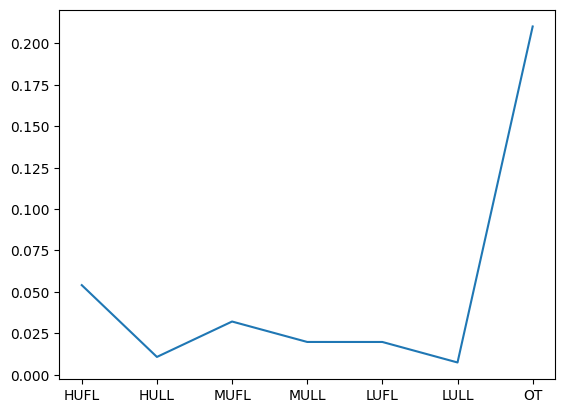

In [34]:
attr_df.abs().mean(axis=0).plot()

## 각 시간 별 영향 추이
* 각 시간별로 중요한 정도를 계산할 수 있음

<AxesSubplot: >

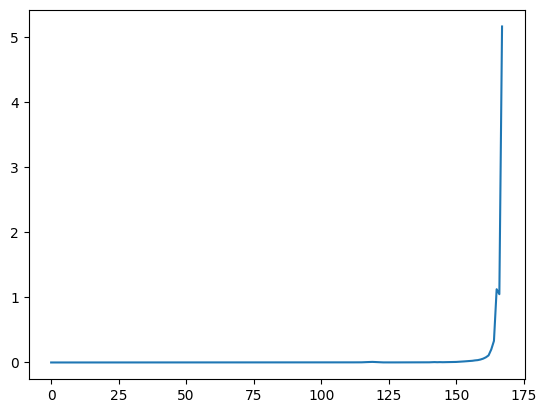

In [35]:
attr_df.abs().mean(axis = 1).plot()

## 각 피쳐별로 시간에 따른 영향 추이

<AxesSubplot: >

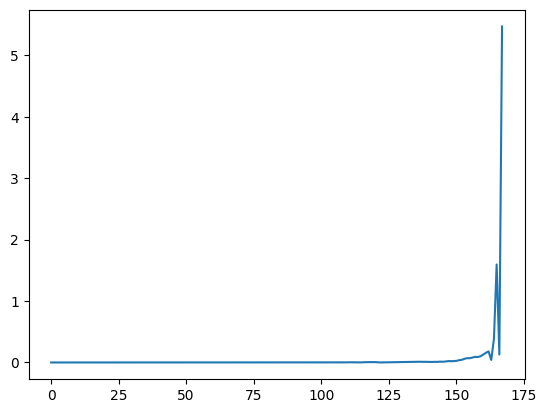

In [36]:
attr_df['HUFL'].abs().plot()

<AxesSubplot: >

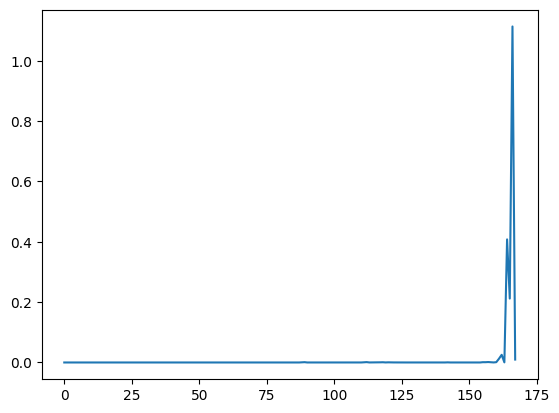

In [37]:
attr_df['HULL'].abs().plot()

<AxesSubplot: >

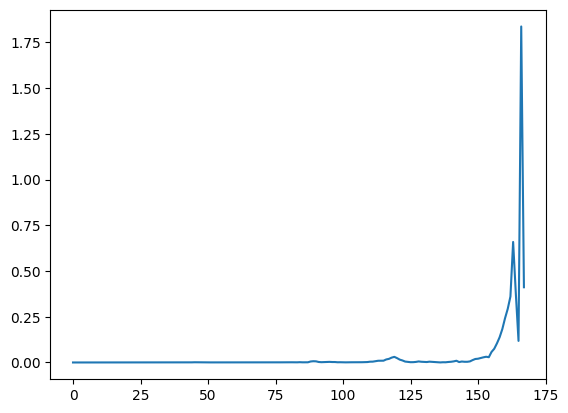

In [38]:
attr_df['MUFL'].abs().plot()

<AxesSubplot: >

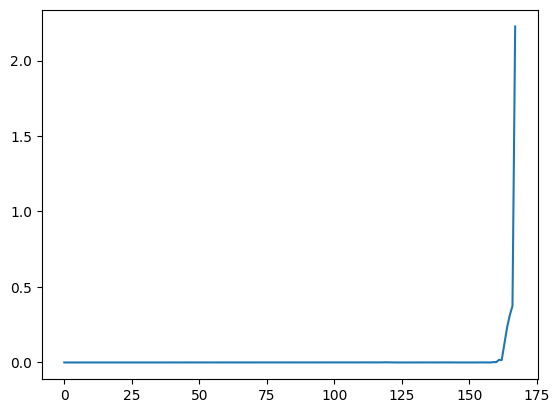

In [39]:
attr_df['MULL'].abs().plot()

<AxesSubplot: >

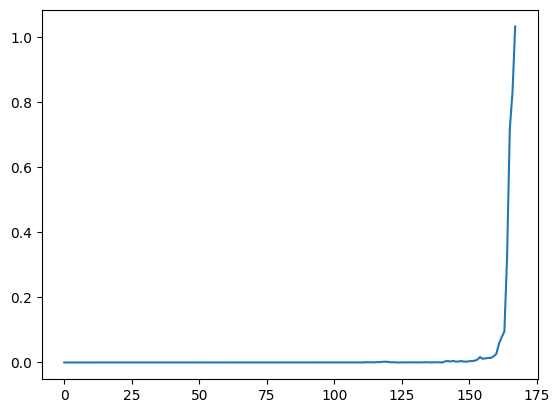

In [40]:
attr_df['LUFL'].abs().plot()

<AxesSubplot: >

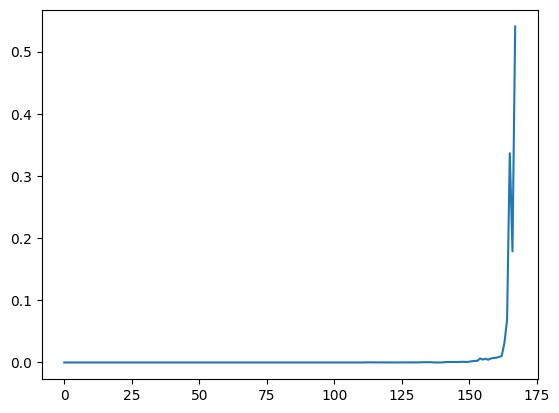

In [41]:
attr_df['LULL'].abs().plot()

<AxesSubplot: >

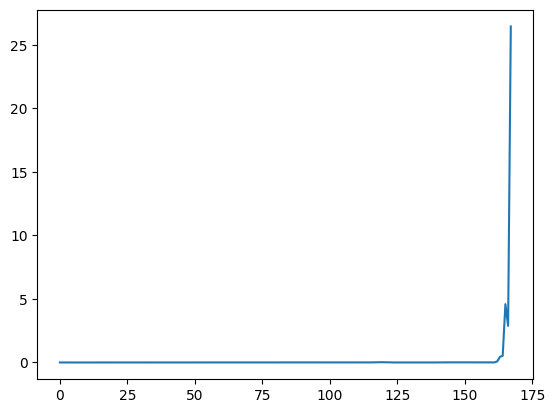

In [42]:
attr_df['OT'].abs().plot()

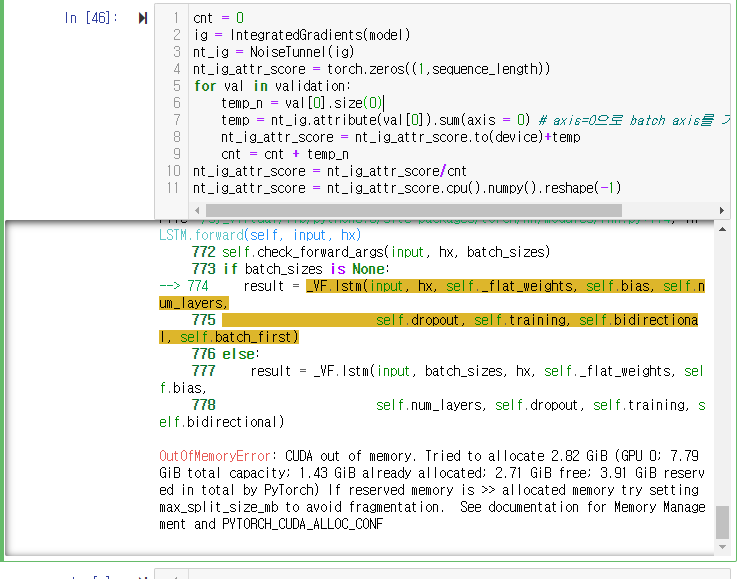

In [43]:
sequence_length

168

In [44]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = np.zeros((1,sequence_length))
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0)
        temp = nt_ig.attribute(val).abs()
        # 각 attribution score의 절대값을 합한다.
        # 이로써 각 시간별로 영향도를 구함
        # 이 부분이 abs를 씌우는게 절대적인 영향을 반영하는데에 맞는 것 같다.
        # 이전까진 씌우지 않았음
        temp = temp.to("cpu").detach().numpy().reshape(-1,feature_size)
        temp = temp.sum(axis=1) 
        nt_ig_attr_score = nt_ig_attr_score+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt

In [45]:
nt_ig_attr_score.reshape(-1)

array([3.88250571e-04, 4.27960284e-04, 4.32867634e-04, 4.32780595e-04,
       4.37798117e-04, 4.46739607e-04, 4.55981410e-04, 4.72474456e-04,
       4.78157009e-04, 4.89847198e-04, 5.00957596e-04, 5.19324207e-04,
       5.30032212e-04, 5.44023234e-04, 5.64060842e-04, 5.80576265e-04,
       6.01093986e-04, 6.19175007e-04, 6.36779906e-04, 6.61505199e-04,
       6.81177794e-04, 7.00991320e-04, 7.27572654e-04, 7.43373340e-04,
       7.60702985e-04, 7.79101507e-04, 7.88327943e-04, 8.06840361e-04,
       8.15953519e-04, 8.24017865e-04, 8.40037436e-04, 8.46300482e-04,
       8.63651485e-04, 8.77467511e-04, 8.89244227e-04, 9.17517930e-04,
       9.45745874e-04, 9.73588262e-04, 9.99167880e-04, 1.03942538e-03,
       1.07129689e-03, 1.10808730e-03, 1.13816450e-03, 1.18011488e-03,
       1.22020777e-03, 1.26800121e-03, 1.31251937e-03, 1.35656489e-03,
       1.37811940e-03, 1.40216903e-03, 1.42482258e-03, 1.44458064e-03,
       1.46497865e-03, 1.48160006e-03, 1.50610266e-03, 1.54546771e-03,
      

<AxesSubplot: >

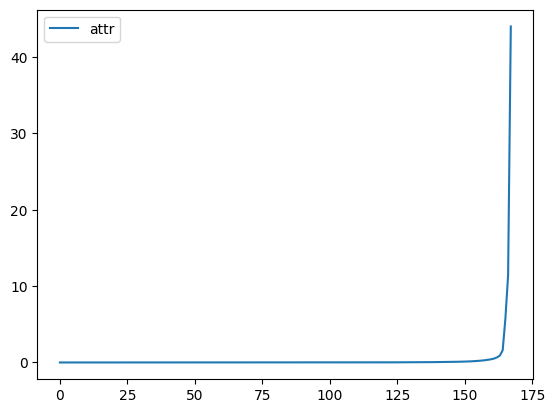

In [46]:
total_mean_attr_df = pd.DataFrame({"attr":nt_ig_attr_score.reshape(-1)})
total_mean_attr_df.plot()

In [47]:
temp.size()

TypeError: 'int' object is not callable

In [ ]:
for val_batch in validation:
    print(val_batch[0])
    for val in val_batch[0]:
        print(val)